# Partie B : Création d’un DataFrame et exécution de requêtes analytiques
Lancez un Jupyter NoteBook puis à partir du package pyspark.sql créez une SparkSession, puis répondez aux questions suivantes en utilisant soit la méthode sql de SparkSession, soit l’API DataFrame.


# Debut

In [60]:
# 📦 Imports nécessaires
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import (
    to_timestamp, unix_timestamp, round, month, dayofyear, col, coalesce
)
import glob

# ⚙️ Configuration Spark
conf = SparkConf() \
    .setAppName("Analyse_CitiBike_2016") \
    .set("spark.driver.memory", "8g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

# 📂 Récupérer tous les fichiers CSV de 2016
csv_paths = glob.glob("C:/Users/HP/Projet_Citibike_NYC_2016/2016-citibike-tripdata/data/2016/*.csv")

# 🔄 Fonction pour normaliser les noms de colonnes
def normalize_columns(df):
    for col_name in df.columns:
        df = df.withColumnRenamed(col_name, col_name.strip().lower().replace(' ', '_'))
    return df


# 1.Création  d'un DataFrame tripdataDF à partir des fichiers csv téléchargés.


In [61]:
# 📊 Chargement et union de tous les fichiers CSV

# 1.Créer un DataFrame tripdataDF à partir des fichiers csv téléchargés.
tripdataDF = None
for path in csv_paths:
    df = spark.read.option("header", "true").csv(path)
    df = normalize_columns(df)
    tripdataDF = df if tripdataDF is None else tripdataDF.unionByName(df, allowMissingColumns=True)

# 2.Opérez à partir d’un pré-traitement, au nettoyage des données et à la standardisation du format des données de type datetime.

In [62]:
for col_name in tripdataDF.columns:
    print(col_name)

tripduration
starttime
stoptime
start_station_id
start_station_name
start_station_latitude
start_station_longitude
end_station_id
end_station_name
end_station_latitude
end_station_longitude
bikeid
usertype
birth_year
gender
trip_duration
start_time
stop_time
bike_id
user_type


In [63]:
# 📊 Chargement et union de tous les fichiers CSV

# 1.Créer un DataFrame tripdataDF à partir des fichiers csv téléchargés.
tripdataDF = None
for path in csv_paths:
    df = spark.read.option("header", "true").csv(path)
    df = normalize_columns(df)
    tripdataDF = df if tripdataDF is None else tripdataDF.unionByName(df, allowMissingColumns=True)


#Opérez à partir d’un pré-traitement, au nettoyage des données et à la standardisation du format des données de type datetime.
# ✅ Conversion  des dates
tripdataDF = tripdataDF \
    .withColumn("start_time", coalesce(
        to_timestamp("starttime", "M/d/yyyy H:mm:ss"),
        to_timestamp("start_time", "yyyy-MM-dd HH:mm:ss"),
     
    )) \
    .withColumn("end_time", coalesce(
        to_timestamp("stop_time", "yyyy-MM-dd HH:mm:ss"),
        to_timestamp("stoptime", "M/d/yyyy H:mm:ss")
    ))

##  Colonnes supplémentaires :mois, jour de l'année

In [64]:
#  Colonnes supplémentaires : durée, mois, jour de l'année
tripdataDF = tripdataDF \
    .withColumn("month", month("start_time")) \
    .withColumn("day_of_year", dayofyear("start_time"))

In [65]:
for col_name in tripdataDF.columns:
    print(col_name)


tripduration
starttime
stoptime
start_station_id
start_station_name
start_station_latitude
start_station_longitude
end_station_id
end_station_name
end_station_latitude
end_station_longitude
bikeid
usertype
birth_year
gender
trip_duration
start_time
stop_time
bike_id
user_type
end_time
month
day_of_year


# 3.Donnez pour chaque mois le nombre de trajets effectués. Tracez le diagramme en bâtons correspondant.

In [66]:

# 🔍 Affichage de la distribution des trajets par mois
tripdataDF.groupBy("month") \
    .count() \
    .withColumnRenamed("count", "nbre_de_trajet") \
    .orderBy("month") \
    .show(20)


+-----+--------------+
|month|nbre_de_trajet|
+-----+--------------+
|    1|        509478|
|    2|        560874|
|    3|        919921|
|    4|       1013149|
|    5|       1212280|
|    6|       1460318|
|    7|       1380110|
|    8|       1557663|
|    9|       1648856|
|   10|       1573872|
|   11|       1196942|
|   12|        812192|
+-----+--------------+



##  Tracez le diagramme en bâtons correspondant.


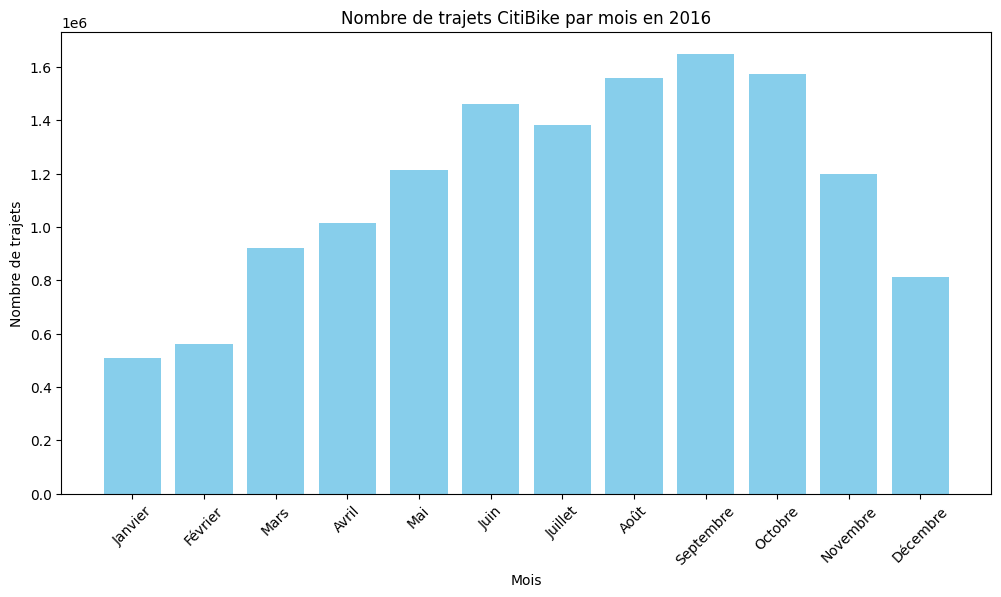

In [67]:
import matplotlib.pyplot as plt

# Récupérer les données agrégées dans un DataFrame Spark
df_counts = tripdataDF.groupBy("month") \
    .count() \
    .withColumnRenamed("count", "nbre_de_trajet") \
    .orderBy("month")

# Convertir en Pandas DataFrame
pdf = df_counts.toPandas()

months_names = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
                'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

pdf['mois_nom'] = pdf['month'].apply(lambda x: months_names[int(x)-1] if x is not None and 1 <= x <=12 else 'Inconnu')

# Tracer le diagramme en bâtons
plt.figure(figsize=(12,6))
plt.bar(pdf['mois_nom'], pdf['nbre_de_trajet'], color='skyblue')
plt.xlabel('Mois')
plt.ylabel('Nombre de trajets')
plt.title('Nombre de trajets CitiBike par mois en 2016')
plt.xticks(rotation=45)
plt.show()


# 4. Calculez pour chaque jour (1 à 365) le nombre de trajets effectués. Représentez la courbe correspondante.

In [68]:
# Grouper par jour et compter les trajets
df_par_jour = tripdataDF.groupBy("day_of_year") \
    .count() \
    .withColumnRenamed("count", "nbre_de_trajets") \
    .orderBy("day_of_year")

# Afficher un aperçu
df_par_jour.show(truncate=False, n=df_par_jour.count())


+-----------+---------------+
|day_of_year|nbre_de_trajets|
+-----------+---------------+
|1          |11009          |
|2          |14587          |
|3          |15499          |
|4          |19593          |
|5          |18053          |
|6          |24569          |
|7          |27773          |
|8          |28709          |
|9          |20846          |
|10         |14275          |
|11         |22937          |
|12         |25211          |
|13         |21133          |
|14         |23780          |
|15         |28435          |
|16         |19178          |
|17         |12024          |
|18         |12718          |
|19         |17281          |
|20         |23420          |
|21         |23672          |
|22         |20950          |
|27         |6761           |
|28         |11946          |
|29         |16028          |
|30         |12973          |
|31         |16118          |
|32         |24334          |
|33         |28528          |
|34         |16203          |
|35       

# Représentez la courbe correspondante.

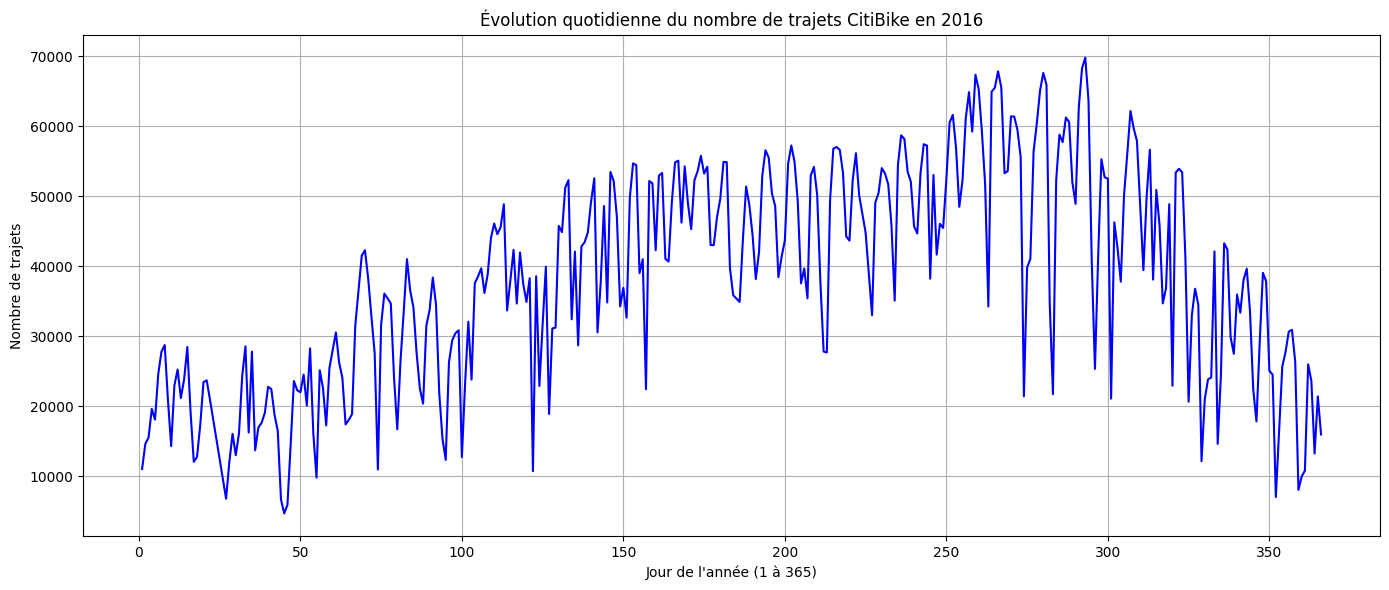

In [69]:
import matplotlib.pyplot as plt

# Convertir le résultat Spark en Pandas pour le tracé
pdf_par_jour = df_par_jour.toPandas()

# Tracer la courbe
plt.figure(figsize=(14,6))
plt.plot(pdf_par_jour["day_of_year"], pdf_par_jour["nbre_de_trajets"], color='blue')
plt.xlabel("Jour de l'année (1 à 365)")
plt.ylabel("Nombre de trajets")
plt.title("Évolution quotidienne du nombre de trajets CitiBike en 2016")
plt.grid(True)
plt.tight_layout()
plt.show()


# 5. Donnez pour chaque station de départ et pour chaque mois le nombre d’utilisateurs

In [70]:
# Calcul du nombre d'utilisateurs par station de départ et par mois
utilisateurs_par_station_mois = tripdataDF.groupBy("start_station_name", "month") \
    .count() \
    .withColumnRenamed("count", "nbre_utilisateurs") \
    .orderBy("start_station_name", "month")

# Affichage
utilisateurs_par_station_mois.show(truncate=False, n=utilisateurs_par_station_mois.count())

+----------------------------------------------+-----+-----------------+
|start_station_name                            |month|nbre_utilisateurs|
+----------------------------------------------+-----+-----------------+
|1 Ave & E 15 St                               |1    |2740             |
|1 Ave & E 15 St                               |2    |3007             |
|1 Ave & E 15 St                               |3    |4730             |
|1 Ave & E 15 St                               |4    |5011             |
|1 Ave & E 15 St                               |5    |5548             |
|1 Ave & E 15 St                               |6    |6564             |
|1 Ave & E 16 St                               |7    |6131             |
|1 Ave & E 16 St                               |8    |6358             |
|1 Ave & E 16 St                               |9    |13               |
|1 Ave & E 16 St                               |10   |3446             |
|1 Ave & E 16 St                               |11 

# 6. Donnez le taux de fréquentation pour chaque station de départ. Représentez le résultat obtenu à l’aide d’un diagramme de votre choix.


In [71]:
#Calcul du nombre total de trajets
total_trajets = tripdataDF.count()
#Étape 2 : Calcul du taux de fréquentation par station
frequentation_station = tripdataDF.groupBy("start_station_name") \
    .count() \
    .withColumn("taux_frequentation", round((col("count") / total_trajets) * 100, 3)) \
    .withColumnRenamed("count", "nbre_trajets") \
    .orderBy(col("taux_frequentation").desc())

frequentation_station.show(truncate=False, n=frequentation_station.count())


+----------------------------------------------+------------+------------------+
|start_station_name                            |nbre_trajets|taux_frequentation|
+----------------------------------------------+------------+------------------+
|Pershing Square North                         |150523      |1.087             |
|W 21 St & 6 Ave                               |100723      |0.727             |
|E 17 St & Broadway                            |99486       |0.719             |
|West St & Chambers St                         |98309       |0.71              |
|Broadway & E 22 St                            |97351       |0.703             |
|8 Ave & W 33 St                               |85339       |0.616             |
|Broadway & E 14 St                            |84407       |0.61              |
|Greenwich Ave & 8 Ave                         |80934       |0.585             |
|Cleveland Pl & Spring St                      |80794       |0.584             |
|W 20 St & 11 Ave           

# Représentez le résultat obtenu à l’aide d’un diagramme de votre choix.

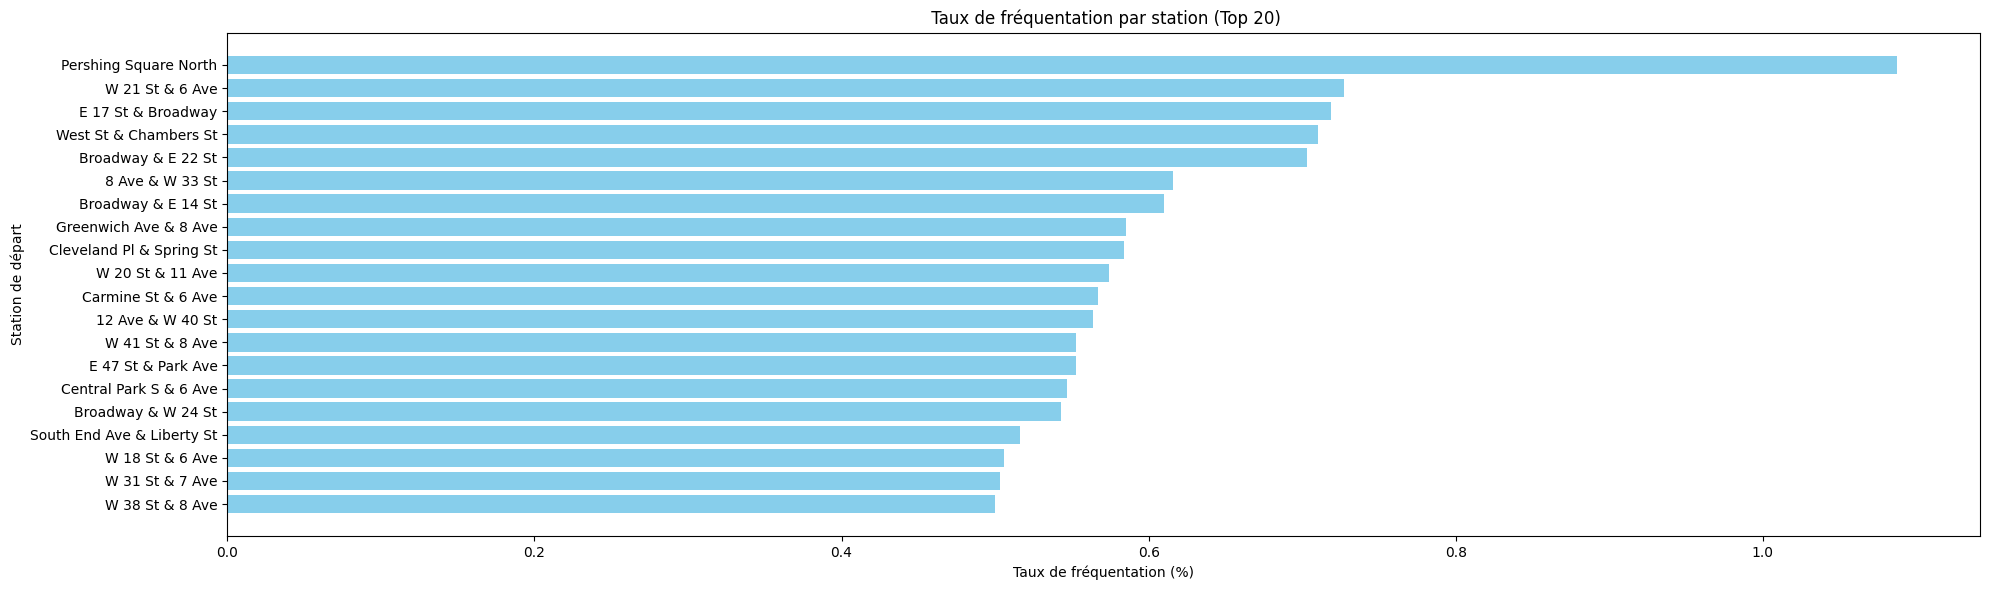

In [72]:
# Conversion en Pandas pour affichage
frequentation_pd = frequentation_station.select("start_station_name", "taux_frequentation").limit(20).toPandas()

# Tracé du diagramme

plt.figure(figsize=(20, 6))
plt.barh(frequentation_pd["start_station_name"], frequentation_pd["taux_frequentation"], color='skyblue')
plt.xlabel("Taux de fréquentation (%)")
plt.ylabel("Station de départ")
plt.title(" Taux de fréquentation par station (Top 20)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 7. Calculez et affichez pour chaque trajet identifié sa durée moyenne, minimale et maximale.


In [73]:
for col_name in tripdataDF.columns:
    print(col_name)


tripduration
starttime
stoptime
start_station_id
start_station_name
start_station_latitude
start_station_longitude
end_station_id
end_station_name
end_station_latitude
end_station_longitude
bikeid
usertype
birth_year
gender
trip_duration
start_time
stop_time
bike_id
user_type
end_time
month
day_of_year


In [74]:
from pyspark.sql.functions import col, coalesce

# Fusionner les deux colonnes dans une seule colonne standard : 'tripduration'
tripdataDF = tripdataDF.withColumn(
    "tripduration",
    coalesce(col("tripduration"), col("trip_duration").cast("int"))
)

# Supprimer l'autre colonne si elle existe
if "trip_duration" in tripdataDF.columns:
    tripdataDF = tripdataDF.drop("trip_duration")


In [75]:
for col_name in tripdataDF.columns:
    print(col_name)

tripduration
starttime
stoptime
start_station_id
start_station_name
start_station_latitude
start_station_longitude
end_station_id
end_station_name
end_station_latitude
end_station_longitude
bikeid
usertype
birth_year
gender
start_time
stop_time
bike_id
user_type
end_time
month
day_of_year


In [76]:
from pyspark.sql.functions import avg, min, max, round, col

duree_par_trajet = tripdataDF.groupBy("start_station_name", "end_station_name") \
    .agg(
        round(avg(col("tripduration"))).alias("Durée_moyenne (min)"),
        round(min(col("tripduration"))).alias("Durée_minimale (min)"),
        round(max(col("tripduration"))).alias("Durée_maximale (min)")
    ) \
    .orderBy("Durée_moyenne (min)", ascending=False)

duree_par_trajet.show(truncate=False, n=duree_par_trajet.count())


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Version de la question avec des limites pour pouvoir afficher 

In [77]:
# Ne garder que les trajets raisonnables : moins de 2 heures
filteredDF = tripdataDF.filter((col("tripduration") > 60) & (col("tripduration") < 7200))  # entre 1 min et 2h

# Recalcul avec données filtrées
duree_par_trajet = filteredDF.groupBy("start_station_name", "end_station_name") \
    .agg(
        round(avg(col("tripduration"))).alias("Durée_moyenne (min)"),
        round(min(col("tripduration"))).alias("Durée_minimale (min)"),
        round(max(col("tripduration"))).alias("Durée_maximale (min)")  
    ) \
    .orderBy("Durée_moyenne (min)", ascending=False)

duree_par_trajet.show(100,  truncate=False)



+---------------------------------------------+---------------------------------+-------------------+--------------------+--------------------+
|start_station_name                           |end_station_name                 |Durée_moyenne (min)|Durée_minimale (min)|Durée_maximale (min)|
+---------------------------------------------+---------------------------------+-------------------+--------------------+--------------------+
|South St & Gouverneur Ln                     |5 Ave & E 78 St                  |7185.0             |7185                |7185                |
|Kane St & Clinton St                         |E 76 St & 3 Ave                  |7179.0             |7179                |7179                |
|Greenwich St & Hubert St                     |McGuinness Blvd & Eagle St       |7178.0             |7178                |7178                |
|Union Ave & Wallabout St                     |Rivington St & Ridge St          |7168.0             |7168                |7168          

# le fichier csv à été joint dans le classroom

In [78]:
from pyspark.sql.functions import avg, min, max, round, col

duree_par_trajet = tripdataDF.groupBy("start_station_name", "end_station_name") \
    .agg(
        round(avg(col("tripduration"))).alias("Durée_moyenne (min)"),
        round(min(col("tripduration"))).alias("Durée_minimale (min)"),
        round(max(col("tripduration"))).alias("Durée_maximale (min)")
    ) \
    .orderBy("Durée_moyenne (min)", ascending=True)
duree_par_trajet.toPandas().to_csv("duree_par_trajet.csv", index=False)

# Message de confirmation
print("✅ Le fichier 'duree_par_trajet.csv' a été créé avec succès.")


✅ Le fichier 'duree_par_trajet.csv' a été créé avec succès.
